## States for the Supervisor

In [5]:
%%writefile ../src/deep_research/state_multi_agent_supervisor.py

from typing_extensions import TypedDict, Annotated, Sequence, List
from langchain_core.messages import BaseMessage
from langchain_core.messages.tool import ToolCall
from langgraph.graph.message import add_messages
import operator
from langchain_core.tools import tool
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    This class represents the state of the research supervisor
    """
    supervisor_messages : Annotated[Sequence[BaseMessage], add_messages]
    research_brief : str
    notes : Annotated[list[str], operator.add] = []
    research_iterations : int = 0
    raw_notes : Annotated[list[str], operator.add] = []

class SupervisorOutput(BaseModel):
    """
    Structured output model, to force LLM to provide message and tools calls
    """
    message : str = Field(
        content="supervisor message"
    )
    tool_calls : List[ToolCall] = Field(
        default_factory=list,
        description="Structured instructions for which tools to call next"
    )

@tool
class ConductResearch(BaseModel):
    """
    Tool for delegating a research task to a specialized sub-agent.
    
    Args:
        research_topic : The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).
    """
    
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

Overwriting ../src/deep_research/state_multi_agent_supervisor.py


## Multi Agent

In [1]:
%%writefile ../src/deep_research/research_supervisor.py

from langchain_core.messages import BaseMessage, filter_messages, SystemMessage, AIMessage, HumanMessage, ToolMessage
from deep_research.state_multi_agent_supervisor import SupervisorState, ConductResearch, ResearchComplete, SupervisorOutput
from deep_research.openrouter import init_chat_model
from langgraph.types import Command
from typing_extensions import Literal
from deep_research.prompts import lead_researcher_prompt
from deep_research.utils import get_today_str, format_tool_instructions
from langgraph.graph import END, START, StateGraph
from deep_research.research_agent import research_agent
from os import getenv
import asyncio

def get_notes_from_tool_calls(messages : list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [msg.content for msg in filter_messages(messages, include_types='tool')]

# Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    # Only apply if running in Jupyter/IPython environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it

tools = [ConductResearch, ResearchComplete]
supervisor_model = init_chat_model(model='x-ai/grok-4-fast:free', temperature=0.3, api_key=getenv('OPENROUTER_API_KEY'))

max_concurrent_researchers = 3
max_researcher_iterations = 6

async def supervisor(state : SupervisorState) -> Command[Literal['supervisor_tools']]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    print('---------------------------------------STATE-----------------------------------------------------')
    print(state)
    structured_model = supervisor_model.with_structured_output(SupervisorOutput)
    system_message = lead_researcher_prompt.format(
        date=get_today_str(),
        tool_info=format_tool_instructions(tools),
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )

    messages = [SystemMessage(content=system_message)] + state.get('supervisor_messages', [])

    result = await structured_model.ainvoke(messages)
    print('-------------------------------------------supervisor_result---------------------------------------------')
    print(result)
    ai_message = AIMessage(content=result.message, tool_calls=result.tool_calls)
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages" : [ai_message],
            "research_iterations" : state.get('research_iterations', 0) + 1
        }
    )

async def supervisor_tools(state : SupervisorState) -> Command[Literal['supervisor', '__end__']]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """

    supervisor_messages = state.get('supervisor_messages',[])
    research_iterations = state.get('research_iterations',0)
    most_recent_message = supervisor_messages[-1]

    tool_messages = []
    all_raw_notes = []
    next_step = 'supervisor'
    should_end = False

    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call['name'] == 'ResearchComplete'
        for tool_call in most_recent_message.tool_calls
    )
    if exceeded_iterations or no_tool_calls or research_complete:
        next_step = END
        should_end = True
    else:
        try:
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls
                if tool_call['name'] == 'ConductResearch'
            ]
    
            if conduct_research_calls:
                coros = [
                    research_agent.ainvoke({
                        "researcher_messages" : HumanMessage(content = tool_call['args']['research_topic']),
                        "research_topic" : tool_call['args']['research_topic']
                    })
                    for tool_call in most_recent_message.tool_calls
                ]
    
                tool_results = await asyncio.gather(*coros)
                print('----------------------------------------------Tool Results-----------------------------------------')
                print(tool_results)
    
                research_tool_messages = [
                    ToolMessage(
                        content = result.get('compressed_research', "Error Synthesizing research report"),
                        id=tool_call['id'],
                        name=tool_call['name']
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
    
                tool_messages.extend(research_tool_messages)
    
                all_raw_notes = [
                    '\n'.join(result.get('raw_notes', []))
                    for result in tool_results
                ]
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END
            
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node('supervisor', supervisor)
supervisor_builder.add_node('supervisor_tools', supervisor_tools)
supervisor_builder.add_edge(START, 'supervisor')
supervisor_agent = supervisor_builder.compile() 


In [2]:
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

---------------------------------------STATE-----------------------------------------------------
{'supervisor_messages': [HumanMessage(content='I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  \non coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, \nusing coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      \nexpert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      \nlocation, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    \nsources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     \nCoffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  \ncustomer feedback about coffee quali

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Planning approach: The user's query is a straightforward fact-finding and ranking task focused on identifying   │
│ and ranking the top coffee shops in San Francisco based solely on coffee quality. This aligns with using a      │
│ single sub-agent for efficiency, as there are no clear independent sub-topics requiring parallelization (e.g.,  │
│ no comparisons across distinct categories or regions within SF that demand separate agents). The agent will     │
│ compile data from specified primary sources, analyze coffee quality metrics like expert reviews, ratings, and   │
│ certifications, and produce a supported ranking using the latest available data up to July 2025. No breakdown   │
│ into smaller sub-tasks is necessary at this stage to avoid unnecessary complexity. After receiving results, I   │
│ will assess if additional research is needed or if I can confidently complete the task.                         │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Identify and evaluate the top coffee shops in San Francisco, California, focusing          │
│ exclusively on coffee quality as the primary criterion for ranking. Research should prioritize primary sources  │
│ such as official coffee shop websites for details on sourcing, roasting, and brewing methods; reputable         │
│ third-party organizations like Coffee Review for expert tastings and scores, the Specialty Coffee Association   │
│ for certifications and standards compliance; and review aggregators like Google Reviews and Yelp for aggregated │
│ customer ratings and comments specifically mentioning coffee quality aspects such as taste, freshness, bean     │
│ origin, and preparation. Ignore factors like ambiance, location, wifi, or food unless they directly influence   │
│ perceived coffee quality (e.g., if poor storage affects bean freshness). Compile a list of at least the top 10  │
│ coffee shops, providing a comparative analysis and ranking based on the latest available data as of July 2025,  │
│ including specific evidence like average ratings (e.g., 4.5+ on Google for coffee mentions), expert scores      │
│ (e.g., 90+ on Coffee Review), and any awards or certifications. Ensure the research is comprehensive, covering  │
│ diverse neighborhoods in San Francisco but centered on quality metrics, and note any trends or standout         │
│ features in high-quality coffee offerings."                                                                     │
│ }                                                                                                               │
│    ID: call_001                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

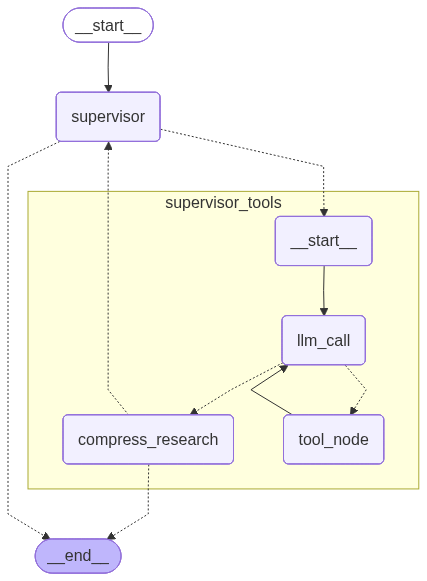

In [6]:
from IPython.display import Image, display

# Show the agent
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))